# 2016 VEST MI

### From Documentation:
Election results from the Michigan Department of State (https://miboecfr.nictusa.com/cgi-bin/cfr/precinct_srch.cgi)
Precinct shapefile from the Michigan Department of State (https://gis-michigan.opendata.arcgis.com/datasets/8ce0f3ce3ff74109ac02a26d34a0f4fc_1)

Michigan has cities split across counties. Two are relevant to their reported election results versus the precinct map (which did not make the split), Fenton and Richmond. Those precincts were merged to reflect the precinct map.

Most counties had "statistical adjustments" that were at the county level, rather than the precinct level. Only two were for party candidates (Huron and Kalkaka), and in those cases, two or fewer votes. The remaining cases were related to "other" votes. Due to the scattered nature of "other" votes, these votes are apportioned to precincts by the split of total votes of precincts within the county.

Detroit allows for absentee votes to be reported by Absentee Voter Counting Boards, which generally contain multiple precincts. These votes are apportioned to precincts by candidate in the same shares that the non-AVCB vote was split among precincts within a county. The linkage between election precinct and AVCB was provided by OpenElections via Derek Willis. Precinct 176 was listed as split between AVCB 37 and AVCB 158, the only precinct in the city that was listed as split. AVCB 158 has no other precinct assigned to it, so all votes went to precinct 176. However, this was a very low number of votes relative to the other AVCBs, so for ease of calculation, 176 was treated as a normal member of AVCB 37 in the disaggregation calculation described above.

G16PREDCli - Hillary Clinton (Democratic Party)
G16PRERTru - Donald J. Trump (Republican Party)
G16PREGSte - Jill Stein (Green Party)
G16PRELJoh - Gary Johnson (Libertarian Party)
G16PREOth - Other Candidates/Write-in Votes


**Files + Sources:** 

2016GEN.zip: Election precinct results from the Michigan Department of State (https://miboecfr.nictusa.com/cgi-bin/cfr/precinct_srch.cgi)

2016_Voting_Precincts-shp.zip: Precinct shapefile from the Michigan Department of State (https://gis-michigan.opendata.arcgis.com/datasets/8ce0f3ce3ff74109ac02a26d34a0f4fc_1)

mi_2016.zip: VEST final file (https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/NH5S2I/4KOZRU&version=46.0)

documentation_2016.txt: VEST's documentation on their 2016 work, all included, not just MI (https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/NH5S2I/A652IT&version=46.0)

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load Partner File

In [2]:
cd /Users/lilyfalk/sandbox/pdv-mi/vest-mi/vest_mi_2016_ar/

/Users/lilyfalk/sandbox/pdv-mi/vest-mi/vest_mi_2016_ar


In [3]:
gdfv = gpd.read_file('./raw-from-source/mi_2016/mi_2016.shp')
gdfv.head()

,VTD2016,Label,G16PREDCli,G16PRERTru,G16PREGSte,G16PRELJoh,G16PREOth,geometry
0,1632100000001,City of Dearborn,581,93,17,11,1,"POLYGON ((-83.14843 42.34469, -83.14861 42.343..."
1,1632100000002,City of Dearborn,560,95,23,9,3,"POLYGON ((-83.16029 42.34644, -83.16027 42.344..."
2,1632100000003,City of Dearborn,756,171,52,13,5,"POLYGON ((-83.16699 42.34247, -83.16815 42.342..."
3,1632100000004,City of Dearborn,406,70,17,8,1,"POLYGON ((-83.17687 42.34399, -83.17806 42.343..."
4,1632100000005,City of Dearborn,453,68,15,9,0,"POLYGON ((-83.18665 42.34561, -83.18657 42.343..."


# Shapefile

In [4]:
## Load, Project
shp = gpd.read_file('./raw-from-source/2016_Voting_Precincts/2016_Voting_Precincts.shp')
crs = gdfv.crs
shp = shp.to_crs(crs)
shp.head()

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry
0,1,3888,1632100000001,163,21000,2016,City of Dearborn,2.489738e+06,6846.254657,"POLYGON ((-83.14843 42.34468, -83.14860 42.343..."
1,2,3889,1632100000002,163,21000,2016,City of Dearborn,1.058362e+06,4621.388992,"POLYGON ((-83.16029 42.34643, -83.16026 42.344..."
2,3,3890,1632100000003,163,21000,2016,City of Dearborn,1.488846e+06,4909.715171,"POLYGON ((-83.16699 42.34246, -83.16815 42.342..."
3,4,3891,1632100000004,163,21000,2016,City of Dearborn,1.187165e+06,4354.743602,"POLYGON ((-83.17687 42.34398, -83.17806 42.343..."
4,5,3892,1632100000005,163,21000,2016,City of Dearborn,1.133548e+06,5460.202887,"POLYGON ((-83.18665 42.34560, -83.18656 42.343..."


# Election Results

In [5]:
## Load + Process format

df = pd.read_csv('./raw-from-source/2016GEN/2016vote.txt', delimiter = '\t', header = None)
#columns defined in documentation
df.columns = ['election_year','election_type','office_code','district_code',
                                     'status_code','candidate_id','county_code','city_town_code','ward_number',
                                     'precinct_number','precinct_label','precinct_votes','na_col']
#Processing
#Filter to office code `1` for president
df = df[df['office_code'] == 1]
#Using the file `2016name.txt` to figure out these candidate codes: 
#- -1130    Stein
#- -1128    Clinton
#- -1110    Trump
#- -1101    Johnson

#Have to replace NaNs in `precinct_label` with empty strings so that we can use it as an index in the pivot
df['precinct_label'] = df['precinct_label'].replace(np.nan, '', regex = True)
## PIVOT RESULTS
df_pivot = df.pivot_table(index = ['county_code','city_town_code','ward_number','precinct_number','precinct_label'],
                         columns = ['candidate_id'],
                        values = ['precinct_votes'],
                         aggfunc = 'sum')
df_pivot.reset_index(inplace = True)

vote_cols_other = [( 'precinct_votes', -1142),
            ( 'precinct_votes', -1141),
            ( 'precinct_votes', -1140),
            ( 'precinct_votes', -1139),
            ( 'precinct_votes', -1137),
            ( 'precinct_votes', -1136),
            ( 'precinct_votes', -1135),
            ( 'precinct_votes', -1112),
            ( 'precinct_votes', -1108)]
df_pivot['G16PREOth'] = 0
for col in vote_cols_other:
    df_pivot['G16PREOth'] = df_pivot['G16PREOth'] + df_pivot[col]
    df_pivot.drop(col[1], axis = 1, level = 1, inplace = True)
    
df_pivot.reset_index(inplace = True)
df_pivot.columns = ['candidate_id','county_code','city_town_code','ward_number','precinct_number','precinct_label',
                              'G16PREGSte','G16PREDCli','G16PRERTru','G16PRELJoh','G16PREOth']
#Comparing results
print('Raw Election result column total sums:')
print(df_pivot[['G16PREDCli','G16PRERTru','G16PREGSte','G16PRELJoh','G16PREOth']].sum())
print('VEST column total sums:')
print(gdfv[['G16PREDCli','G16PRERTru','G16PREGSte','G16PRELJoh','G16PREOth']].sum())

Raw Election result column total sums:
G16PREDCli    2268839
G16PRERTru    2279543
G16PREGSte      51463
G16PRELJoh     172136
G16PREOth       27303
dtype: int64
VEST column total sums:
G16PREDCli    2268839
G16PRERTru    2279543
G16PREGSte      51463
G16PRELJoh     172136
G16PREOth       27303
dtype: int64


## Cleaning Election Results

In [6]:
#### Add County Name
#The SOS results have county codes that are not FIPS codes. Pulled the `county.txt` file to a Sheet and lined it up with county fips codes from Wikipedia. Loading in this file created in Sheets. 
county_names = pd.read_csv('./raw-from-source/county_codes.csv', dtype = {'county_fips':'object'})
df_pivot = df_pivot.merge(county_names, on = 'county_code')

#### Add City/Township Name
#Loading in the `2016city.txt` file that has the corresponding names for the city codes in the election results file
city_codes = pd.read_csv('./raw-from-source/2016GEN/2016city.txt',delimiter='\t',header=None)
city_codes.columns = ['election_year','election_type','county_code','city_town_code','city_town_name','null']
city_codes.drop(['election_year','election_type','null'],axis=1,inplace=True)
df_pivot = df_pivot.merge(city_codes, on = ['county_code','city_town_code'])

# Looking for unique identifier

So, the elections file has 157 more unique identifiers than VEST's final file... Likely caused by satistical adjustments + AVCBs

In [7]:
print(set(gdfv.VTD2016) - set(shp.VTD2016))
print(set(shp.VTD2016) - set(gdfv.VTD2016))

set()
set()


See that `gdfv`, the final VEST file and `shp` the raw shapefile have unique identifiers that match up perfectly.

Check `gdfv` `VTD2016` column to identify different components of the unique id

Check census all geocodes file and find that `City of Dearborn` has `county_fips` = 163, and `county subdiv`(MCDFIPS) = 21000

So, from `shp`, `Jurisdicti` is the `county subdiv`/MCDFIPS code

## Read in Census File to get the MCDFIPs code and more

In [8]:
census = pd.read_csv('./raw-from-source/all-geocodes-v2016.csv')
censusmi = census[census['State Code (FIPS)'] == 26]
#After `Place Code` != 0, repeat values, so want to filter that out. Then see that # unique values = 1520 for County Sub, indicating same as `Juris` in `shp`
censusmi = censusmi[(censusmi['Place Code (FIPS)'] == 0) & (censusmi['County Subdivision Code (FIPS)'] != 0)]


Census file uses "Charter Township" whereas election df just says "Township". Also, census file says "City City" in some places

Seems like best bet is to make `Area Name`s consistent, make column with the county fips joined, then use dictionary to match to the `Juris` code

Before removing all instances of charter from the censusmi, wanted to make sure df does not contain instances, it doesnt
`df_pivot[df_pivot['city_town_name'].str.contains('charter')]
df_pivot[df_pivot['city_town_name'].str.contains('CITY CITY')]`

### Clean census file to make match column

In [9]:
censusmi['city_town_name'] = censusmi['Area Name (including legal/statistical area description)'].str.replace('charter township', 'township')
censusmi['city_town_name'] = censusmi['city_town_name'].str.replace('City city', 'city')
censusmi['city_town_name'] = censusmi['city_town_name'].str.upper()

#set(censusmi['city_town_name'].str.upper()) - set(df_pivot['city_town_name'])
#set(df_pivot['city_town_name']) - set(censusmi['city_town_name'].str.upper())
#Use^ to create dictionary below

census_to_df_city_dict = {'COLDSPRINGS TOWNSHIP': 'COLD SPRINGS TOWNSHIP',
 'DEWITT CITY': 'DE WITT CITY',
 'DEWITT TOWNSHIP': 'DE WITT TOWNSHIP',
 'GUN PLAIN TOWNSHIP': 'GUNPLAIN TOWNSHIP',
 "L'ANSE TOWNSHIP": 'LANSE TOWNSHIP',
 'LAGRANGE TOWNSHIP': 'LA GRANGE TOWNSHIP',
 'PLEASANTVIEW TOWNSHIP': 'PLEASANT VIEW TOWNSHIP',
 'ST. JAMES TOWNSHIP': 'ST JAMES TOWNSHIP',
 'VILLAGE OF CLARKSTON CITY': 'CLARKSTON CITY',
 'VILLAGE OF GROSSE POINTE SHORES CITY': 'GROSSE POINTE SHORES CITY'}

censusmi.loc[censusmi['city_town_name'].isin(census_to_df_city_dict.keys()), 'city_town_name'] = censusmi.loc[censusmi['city_town_name'].isin(census_to_df_city_dict.keys()), 'city_town_name'].map(census_to_df_city_dict)

#Use below to determine next needed replacements:
#df_pivot[(df_pivot['city_town_name'] == 'GROSS POINTE SHORES CITY') | (df_pivot['city_town_name'] == 'GROSSE POINTE SHORES CITY')]
#censusmi[(censusmi['city_town_name'] == 'GROSS POINTE SHORES CITY') | (censusmi['city_town_name'] == 'GROSSE POINTE SHORES CITY')]
censusmi.loc[(censusmi['Area Name (including legal/statistical area description)'] == 'Village of Grosse Pointe Shores city')&(censusmi['County Code (FIPS)']==99), 'city_town_name'] = 'GROSS POINTE SHORES CITY'


### Translate Census file JURISDICTION code in to df
Now that the city town names match, I can create a dictionary - census file juris code to df. First I need a column in each with the county code + the city town name

In [10]:
censusmi['county_city_id'] = censusmi['County Code (FIPS)'].astype(str).str.zfill(3) + censusmi['city_town_name']
df_pivot['county_city_id'] = df_pivot['county_fips'] + df_pivot['city_town_name']
#The census identifier has more values by 8 than the df, so just keep in mind when mapping.
### Apply dictionary to make column in df
county_city_id_to_mcdjuris_dict = pd.Series(censusmi['County Subdivision Code (FIPS)'].values, index = censusmi['county_city_id']).to_dict()
df_pivot['jurisd'] = (df_pivot['county_city_id'].map(county_city_id_to_mcdjuris_dict)).fillna(0).astype('int64')

#gdfv[gdfv['VTD2016'].str.slice(stop = 3) == '001'].head()
#From `gdfv` see that for juris for alcona twp, need 1040 --> 01040

### Compare df and gdfv size/unique id matching

In [11]:
print('# df id values with county, juris, prec#, no ward: ', (df_pivot['county_fips'] + df_pivot['jurisd'].astype(str).str.zfill(5) + df_pivot['precinct_number'].astype(str).str.zfill(3)).nunique())
print('gdfv shape: ', gdfv.shape)
print('# unique values in id with no ward: ', (gdfv['VTD2016'].str.slice(stop = -5) + gdfv['VTD2016'].str.slice(start = -3)).nunique())
### Observe better match rate with ward removed from unique identifier. Explore more about the unique ids:
print('# vals in gdfv not in df with no ward in id: ', len(set(gdfv['VTD2016'].str.slice(stop = -5) + gdfv['VTD2016'].str.slice(start = -3)) - set(df_pivot['county_fips'] + df_pivot['jurisd'].astype(str).str.zfill(5) + df_pivot['precinct_number'].astype(str).str.zfill(3))))
print('# vals in df not in gdfv with no ward in id: ', len(set(df_pivot['county_fips'] + df_pivot['jurisd'].astype(str).str.zfill(5) + df_pivot['precinct_number'].astype(str).str.zfill(3)) - set(gdfv['VTD2016'].str.slice(stop = 8) + gdfv['VTD2016'].str.slice(start = 10))))

# df id values with county, juris, prec#, no ward:  4950
gdfv shape:  (4810, 8)
# unique values in id with no ward:  4686
# vals in gdfv not in df with no ward in id:  53
# vals in df not in gdfv with no ward in id:  317


### Look more into ward use and needs for id creation
See from sample id that taking ward out, `VTD2016` does in fact rely on the ward # to make the id unique

In [12]:
#Observe highest value count for '00' in gdfv and df, but notice that the value counts do not match up - df has far too many '00' values
print('gdfv ward # value counts:')
print(gdfv['VTD2016'].str.slice(start = -5, stop = -3).value_counts())
print('df ward # value counts:')
print(df_pivot['ward_number'].value_counts())

gdfv ward # value counts:
00    3705
01     236
02     229
03     196
04     148
05     129
06      77
07      76
08       7
09       6
10       1
Name: VTD2016, dtype: int64
df ward # value counts:
0    4503
1     179
2     130
3     110
4      64
5      49
6      19
7      10
8       7
9       6
Name: ward_number, dtype: int64


In [13]:
#create draft id to match gdfv and shp that includes ward... will observe that the ward number does not match well with the other two files
df_pivot['VTD2016_draft'] = df_pivot['county_fips'] + df_pivot['jurisd'].astype(str).str.zfill(5) + df_pivot['ward_number'].astype(str).str.zfill(2) + df_pivot['precinct_number'].astype(str).str.zfill(3)+df_pivot['precinct_label'].str.strip()
#Observe poor match rate for this new draft id
print('# id values in shp not in df: ', len(set(shp.VTD2016) - set(df_pivot.VTD2016_draft)))
print('# id values in df not in shp: ', len(set(df_pivot.VTD2016_draft) - set(shp.VTD2016)))

#sum the difference in value counts for all ward #s not equal to zero
print('sum of ward# value count differences not equal to zero: ', (236-179)+ (229-130)+(196 - 110)+(148-64) + (129-49) + (77-19)+(76-10))
#See that half of mismatch can likely be attributed to ward mismatch

print('# ids in df not containing AVCB not in shp id list: ', len(set(df_pivot['VTD2016_draft'][df_pivot['VTD2016_draft'].str.slice(start = -4)!='AVCB']) - set(shp.VTD2016)))


# id values in shp not in df:  567
# id values in df not in shp:  834
sum of ward# value count differences not equal to zero:  530
# ids in df not containing AVCB not in shp id list:  624


From `readme.txt`, see that `ward` field is 00 if "not applicable"...

See from removing AVCBs that match rate improves without - need to fix using csv from brian
TODO:
- modify AVCB as needed
- modify ward

In [14]:
#Observe 900 added to normal precinct values in the AVCBs
print('df AVCB values: ')
print(df_pivot['VTD2016_draft'][df_pivot['VTD2016_draft'].str.slice(start = -4)=='AVCB'])

print('# unique ids in df and not avcb without ward: ', (df_pivot['VTD2016_draft'][df_pivot['VTD2016_draft'].str.slice(start = -4)!='AVCB'].str.slice(stop=-5)+df_pivot['precinct_number'].astype(str).str.zfill(3)).nunique())
print('# unique ids in gdfv and not avcb without ward: ',(gdfv.VTD2016.str.slice(stop=-5)+gdfv.VTD2016.str.slice(start=-3)).nunique())

df AVCB values: 
380      0276090000901AVCB
386      0277394000901AVCB
494      0372412000901AVCB
865      0511218000901AVCB
1729     0874606000901AVCB
               ...        
4763    16322000001068AVCB
4764    16322000001069AVCB
4765    16322000001070AVCB
4766    16322000001071AVCB
4767    16322000001072AVCB
Name: VTD2016_draft, Length: 210, dtype: object
# unique ids in df and not avcb without ward:  4742
# unique ids in gdfv and not avcb without ward:  4686


Question is, why does the precinct shapefile wards not match the precinct election results
- say how many confirm what
- say that vest doesnt say how they did it
- we cant follow their steps to get to same conclusion


# ---- begin avcb precinct testing/decoding ----

Read in avcb translation csv thanks to Brian Amos - in report mark as inaccessible file

In [34]:
avcb_csv = pd.read_csv('./raw-from-source/detroit16_readable.csv', names=['prec_num', 'avcb_num'])
avcb_csv

,prec_num,avcb_num
0,1,21
1,2,21
2,3,21
3,4,22
4,5,13
...,...,...
485,486,65
486,487,166
487,488,74
488,489,86


In [39]:
df_pivot['precinct_number'][(df_pivot['precinct_label']=='AVCB')&(df_pivot['county_name']=='WAYNE')].value_counts()

1024    1
970     1
962     1
963     1
964     1
       ..
910     1
911     1
912     1
913     1
1023    1
Name: precinct_number, Length: 172, dtype: int64

In [36]:
pd.Series(avcb_csv['avcb_num'].values, index = avcb_csv['prec_num']).to_dict()

{1: '21',
 2: '21',
 3: '21',
 4: '22',
 5: '13',
 6: '13',
 7: '14',
 8: '15',
 9: '14',
 10: '10',
 11: '1',
 12: '15',
 13: '16',
 14: '1',
 15: '1',
 16: '16',
 17: '1',
 18: '1',
 19: '2',
 20: '2',
 21: '2',
 22: '16',
 23: '17',
 24: '17',
 25: '17',
 26: '18',
 27: '18',
 28: '154',
 29: '18',
 30: '19',
 31: '2',
 32: '19',
 33: '3',
 34: '20',
 35: '7',
 36: '155',
 37: '7',
 38: '3',
 39: '3',
 40: '4',
 41: '4',
 42: '4',
 43: '5',
 44: '5',
 45: '7',
 46: '7',
 47: '23',
 48: '7',
 49: '8',
 50: '8',
 51: '8',
 52: '8',
 53: '9',
 54: '24',
 55: '23',
 56: '155',
 57: '24',
 58: '24',
 59: '9',
 60: '9',
 61: '34',
 62: '33',
 63: '25',
 64: '25',
 65: '25',
 66: '26',
 67: '26',
 68: '26',
 69: '27',
 70: '27',
 71: '27',
 72: '27',
 73: '27',
 74: '28',
 75: '28',
 76: '9',
 77: '28',
 78: '28',
 79: '28',
 80: '29',
 81: '5',
 82: '6',
 83: '6',
 84: '6',
 85: '6',
 86: '33',
 87: '29',
 88: '33',
 89: '55',
 90: '161',
 91: '55',
 92: '55',
 93: '55',
 94: '56',
 95: '

Look at examples of specific IDs to try to reverse engineer what Amos file is telling me

In [152]:
df_pivot['VTD2016_draft'][df_pivot['VTD2016_draft'].str.slice(start = -7)=='072AVCB']

4767    16322000001072AVCB
Name: VTD2016_draft, dtype: object

In [153]:
shp['VTD2016'][shp['VTD2016'].str.contains('0276090000')]

416    0276090000001
417    0276090000002
Name: VTD2016, dtype: object

In [154]:
df_pivot['precinct_number'][df_pivot['precinct_label'] == 'AVCB'].value_counts()

901     14
902      9
903      7
904      4
905      4
        ..
917      1
918      1
919      1
920      1
1023     1
Name: precinct_number, Length: 172, dtype: int64

In [155]:
df_pivot[(df_pivot['precinct_label'] == 'AVCB')&(df_pivot['county_name'] == 'WAYNE')].shape

(172, 18)

In [156]:
(df_pivot['precinct_number'][(df_pivot['precinct_label'] == 'AVCB')&(df_pivot['county_name'] == 'WAYNE')] - 900).unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172])

In [157]:
avcb_csv.precinctid[avcb_csv.precinctid != '37/158'].astype('int64').max()

172

In [158]:
sorted(avcb_csv.precinctid[avcb_csv.precinctid != '37/158'].astype('int64').unique())

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172]

In [159]:
avcb_csv

,AVCBid,precinctid
0,1,21
1,2,21
2,3,21
3,4,22
4,5,13
...,...,...
485,486,65
486,487,166
487,488,74
488,489,86


### From mtg with Adriana - 
- precinct # - 900 = precinctid from csv --- check if 900 occurs in other ids?
- make into dictionary, use .loc to apply to precinct_number, then make new VTD 2016

In [160]:
print(len(set(df_pivot['VTD2016_draft']) - set(gdfv['VTD2016'])))
print(len(set(gdfv['VTD2016']) - set(df_pivot['VTD2016_draft'])))
print(777-566)

834
567
211


In [161]:
print(len(df_pivot['VTD2016_draft'][df_pivot['VTD2016_draft'].str.contains('AVCB')]))
print(df_pivot.shape[0], gdfv.shape[0], df_pivot.shape[0] - gdfv.shape[0])

210
5077 4810 267


Here, we can see that there are 566 values that do not match between the datasets, and that in addition, there are 210 IDs that need to be redistributed, which also accounts for the difference in dataset sizes

In [162]:
avcb_wayne_only_df = df_pivot[(df_pivot['precinct_label'] == 'AVCB')&(df_pivot['county_name'] == 'WAYNE')]

In [163]:
avcb_wayne_only_df['new_vtd_minus900_precnum']=avcb_wayne_only_df['county_fips'] + avcb_wayne_only_df['jurisd'].astype(str).str.zfill(5) + avcb_wayne_only_df['ward_number'].astype(str).str.zfill(2)+(avcb_wayne_only_df['precinct_number']-900).astype(str).str.zfill(3)

<ipython-input-163-1d88123238a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avcb_wayne_only_df['new_vtd_minus900_precnum']=avcb_wayne_only_df['county_fips'] + avcb_wayne_only_df['jurisd'].astype(str).str.zfill(5) + avcb_wayne_only_df['ward_number'].astype(str).str.zfill(2)+(avcb_wayne_only_df['precinct_number']-900).astype(str).str.zfill(3)


In [164]:
len(set(avcb_wayne_only_df['new_vtd_minus900_precnum']) - set(gdfv['VTD2016']))

172

In [165]:
avcb_wayne_only_df['new_vtd_minus900_precnum']

4596    1632200000001
4597    1632200000002
4598    1632200000003
4599    1632200000004
4600    1632200000005
            ...      
4763    1632200000168
4764    1632200000169
4765    1632200000170
4766    1632200000171
4767    1632200000172
Name: new_vtd_minus900_precnum, Length: 172, dtype: object

In [166]:
gdfv[(gdfv['VTD2016'].str.contains('163'))&(gdfv['VTD2016'].str.contains('171'))]

,VTD2016,Label,G16PREDCli,G16PRERTru,G16PREGSte,G16PRELJoh,G16PREOth,geometry,join_tst1
3721,1632200005171,City of Detroit,210,16,8,2,0,"POLYGON ((-83.08199 42.38878, -83.08185 42.388...",16322000171


See here that the wards are the problem - the precinct change, it seems, fixed the precinct number problem, but in the df all wards = 00, whereas in the gdfv the wards range from 01-09 excluding 08.

look at both df and gdf with only detroit to compare 

In [167]:
detroit_only_gdfv = gdfv[gdfv['VTD2016'].str.contains('16322000')]

In [168]:
sorted(detroit_only_gdfv.VTD2016.str.slice(start = -3).unique())

['001',
 '002',
 '003',
 '004',
 '005',
 '006',
 '007',
 '008',
 '009',
 '010',
 '011',
 '012',
 '013',
 '014',
 '015',
 '016',
 '017',
 '018',
 '019',
 '020',
 '021',
 '022',
 '023',
 '024',
 '025',
 '026',
 '027',
 '028',
 '029',
 '030',
 '031',
 '032',
 '033',
 '034',
 '035',
 '036',
 '037',
 '038',
 '039',
 '040',
 '041',
 '042',
 '043',
 '044',
 '045',
 '046',
 '047',
 '048',
 '049',
 '050',
 '051',
 '052',
 '053',
 '054',
 '055',
 '056',
 '057',
 '058',
 '059',
 '060',
 '061',
 '062',
 '063',
 '064',
 '065',
 '066',
 '067',
 '068',
 '069',
 '070',
 '071',
 '072',
 '073',
 '074',
 '075',
 '076',
 '077',
 '078',
 '079',
 '080',
 '081',
 '082',
 '083',
 '084',
 '085',
 '086',
 '087',
 '088',
 '089',
 '090',
 '091',
 '092',
 '093',
 '094',
 '095',
 '096',
 '097',
 '098',
 '099',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',


See that detroit precincts range from 000-490. Re-read VEST documentation and understand that AVCB votes need to be split by county according to non-avcb precincts in the county.

### ---- End of AVCB translation testing ----

# Peter additions:

ID Changes DICT is a dictionary I (peter) added that makes some minor ID adjustments to match more precincts.
- can you please share file you used to make these matches?
    - Peter would need to re-create file - come back to if necessary

In [15]:
id_changes_dict = {'0250592000021': '0250592002021', '0250592000010': '0250592001010', '0250592000008': '0250592005008', '0250592000006': '0250592004006', '0250592000012': '0250592002012', '0250592000005': '0250592005005', '0250592000015': '0250592003015', '0250592000016': '0250592003016', '0250592000003': '0250592005003', '0250592000018': '0250592002018', '0250592000014': '0250592004014', '0250592000023': '0250592001023', '0250592000020': '0250592005020', '0250592000017': '0250592003017', '0250592000007': '0250592002007', '0250592000013': '0250592004013', '0250592000001': '0250592003001', '0250592000002': '0250592004002', '0250592000004': '0250592001004', '0250592000022': '0250592001022', '0250592000019': '0250592003019', '0250592000009': '0250592004009', '0250592000011': '0250592005011', '0210752000003': '0210752003001', '0210752000001': '0210752001001', '0210752000004': '0210752004001', '0210752000002': '0210752002001', '1632200000490': '1632200001490', '1632200000489': '1632200006489', '1632200000488': '1632200006488', '1632200000487': '1632200006487', '1632200000486': '1632200006486', '1632200000485': '1632200006485', '1632200000484': '1632200006484', '1632200000483': '1632200006483', '1632200000482': '1632200006482', '1632200000481': '1632200006481', '1632200000480': '1632200006480', '1632200000479': '1632200006479', '1632200000478': '1632200006478', '1632200000477': '1632200006477', '1632200000476': '1632200006476', '1632200000475': '1632200006475', '1632200000474': '1632200006474', '1632200000473': '1632200006473', '1632200000472': '1632200006472', '1632200000471': '1632200006471', '1632200000470': '1632200006470', '1632200000469': '1632200006469', '1632200000468': '1632200006468', '1632200000467': '1632200006467', '1632200000466': '1632200006466', '1632200000465': '1632200006465', '1632200000464': '1632200006464', '1632200000463': '1632200006463', '1632200000462': '1632200006462', '1632200000461': '1632200006461', '1632200000460': '1632200006460', '1632200000459': '1632200006459', '1632200000458': '1632200006458', '1632200000457': '1632200006457', '1632200000456': '1632200005456', '1632200000455': '1632200005455', '1632200000454': '1632200005454', '1632200000453': '1632200006453', '1632200000452': '1632200005452', '1632200000451': '1632200006451', '1632200000450': '1632200006450', '1632200000449': '1632200005449', '1632200000448': '1632200005448', '1632200000447': '1632200005447', '1632200000446': '1632200005446', '1632200000445': '1632200005445', '1632200000444': '1632200005444', '1632200000443': '1632200005443', '1632200000442': '1632200005442', '1632200000441': '1632200005441', '1632200000440': '1632200005440', '1632200000439': '1632200005439', '1632200000438': '1632200005438', '1632200000437': '1632200005437', '1632200000436': '1632200005436', '1632200000435': '1632200005435', '1632200000434': '1632200005434', '1632200000433': '1632200005433', '1632200000432': '1632200005432', '1632200000431': '1632200007431', '1632200000430': '1632200007430', '1632200000429': '1632200007429', '1632200000428': '1632200007428', '1632200000427': '1632200007427', '1632200000426': '1632200007426', '1632200000425': '1632200006425', '1632200000424': '1632200006424', '1632200000423': '1632200006423', '1632200000422': '1632200006422', '1632200000421': '1632200006421', '1632200000420': '1632200006420', '1632200000419': '1632200006419', '1632200000418': '1632200006418', '1632200000417': '1632200006417', '1632200000416': '1632200006416', '1632200000415': '1632200007415', '1632200000414': '1632200007414', '1632200000413': '1632200007413', '1632200000412': '1632200007412', '1632200000411': '1632200007411', '1632200000410': '1632200007410', '1632200000409': '1632200007409', '1632200000408': '1632200007408', '1632200000407': '1632200007407', '1632200000406': '1632200007406', '1632200000405': '1632200007405', '1632200000404': '1632200007404', '1632200000403': '1632200002403', '1632200000402': '1632200007402', '1632200000401': '1632200007401', '1632200000400': '1632200007400', '1632200000399': '1632200007399', '1632200000398': '1632200007398', '1632200000397': '1632200007397', '1632200000396': '1632200007396', '1632200000395': '1632200007395', '1632200000394': '1632200007394', '1632200000393': '1632200007393', '1632200000392': '1632200002392', '1632200000391': '1632200002391', '1632200000390': '1632200007390', '1632200000389': '1632200002389', '1632200000388': '1632200002388', '1632200000387': '1632200002387', '1632200000386': '1632200002386', '1632200000385': '1632200002385', '1632200000384': '1632200002384', '1632200000383': '1632200002383', '1632200000382': '1632200002382', '1632200000381': '1632200002381', '1632200000380': '1632200002380', '1632200000379': '1632200001379', '1632200000378': '1632200001378', '1632200000377': '1632200007377', '1632200000376': '1632200007376', '1632200000375': '1632200007375', '1632200000374': '1632200007374', '1632200000373': '1632200007373', '1632200000372': '1632200007372', '1632200000371': '1632200007371', '1632200000370': '1632200007370', '1632200000369': '1632200007369', '1632200000368': '1632200007368', '1632200000367': '1632200007367', '1632200000366': '1632200007366', '1632200000365': '1632200007365', '1632200000364': '1632200007364', '1632200000363': '1632200007363', '1632200000362': '1632200001362', '1632200000361': '1632200001361', '1632200000360': '1632200001360', '1632200000359': '1632200001359', '1632200000358': '1632200001358', '1632200000357': '1632200001357', '1632200000356': '1632200007356', '1632200000355': '1632200007355', '1632200000354': '1632200001354', '1632200000353': '1632200001353', '1632200000352': '1632200001352', '1632200000351': '1632200001351', '1632200000350': '1632200001350', '1632200000349': '1632200007349', '1632200000348': '1632200007348', '1632200000347': '1632200007347', '1632200000346': '1632200007346', '1632200000345': '1632200007345', '1632200000344': '1632200007344', '1632200000343': '1632200007343',
                     '1632200000342': '1632200007342', '1632200000341': '1632200007341', '1632200000340': '1632200007340', '1632200000339': '1632200007339', '1632200000338': '1632200007338', '1632200000337': '1632200007337', '1632200000336': '1632200007336', '1632200000335': '1632200007335', '1632200000334': '1632200007334', '1632200000333': '1632200007333', '1632200000332': '1632200007332', '1632200000331': '1632200007331', '1632200000330': '1632200007330', '1632200000329': '1632200001329', '1632200000328': '1632200001328', '1632200000327': '1632200001327', '1632200000326': '1632200001326', '1632200000325': '1632200001325', '1632200000324': '1632200001324', '1632200000323': '1632200001323', '1632200000322': '1632200001322', '1632200000321': '1632200001321', '1632200000320': '1632200001320', '1632200000319': '1632200001319', '1632200000318': '1632200001318', '1632200000317': '1632200001317', '1632200000316': '1632200001316', '1632200000315': '1632200001315', '1632200000314': '1632200002314', '1632200000313': '1632200002313', '1632200000312': '1632200001312', '1632200000311': '1632200001311', '1632200000310': '1632200001310', '1632200000309': '1632200001309', '1632200000308': '1632200001308', '1632200000307': '1632200001307', '1632200000306': '1632200001306', '1632200000305': '1632200001305', '1632200000304': '1632200001304', '1632200000303': '1632200001303', '1632200000302': '1632200001302', '1632200000301': '1632200001301', '1632200000300': '1632200001300', '1632200000299': '1632200001299', '1632200000298': '1632200001298', '1632200000297': '1632200001297', '1632200000296': '1632200002296', '1632200000295': '1632200002295', '1632200000294': '1632200002294', '1632200000293': '1632200002293', '1632200000292': '1632200002292', '1632200000291': '1632200002291', '1632200000290': '1632200002290', '1632200000289': '1632200002289', '1632200000288': '1632200002288', '1632200000287': '1632200001287', '1632200000286': '1632200001286', '1632200000285': '1632200001285', '1632200000284': '1632200001284', '1632200000283': '1632200001283', '1632200000282': '1632200001282', '1632200000281': '1632200001281', '1632200000280': '1632200001280', '1632200000279': '1632200001279', '1632200000278': '1632200001278', '1632200000277': '1632200001277', '1632200000276': '1632200001276', '1632200000275': '1632200001275', '1632200000274': '1632200001274', '1632200000273': '1632200001273', '1632200000272': '1632200001272', '1632200000271': '1632200001271', '1632200000270': '1632200001270', '1632200000269': '1632200001269', '1632200000268': '1632200001268', '1632200000267': '1632200001267', '1632200000266': '1632200001266', '1632200000265': '1632200001265', '1632200000264': '1632200001264', '1632200000263': '1632200001263', '1632200000262': '1632200001262', '1632200000261': '1632200001261', '1632200000260': '1632200002260', '1632200000259': '1632200002259', '1632200000258': '1632200002258', '1632200000257': '1632200002257', '1632200000256': '1632200002256', '1632200000255': '1632200002255', '1632200000254': '1632200001254', '1632200000253': '1632200001253', '1632200000252': '1632200001252', '1632200000251': '1632200001251', '1632200000250': '1632200002250', '1632200000249': '1632200002249', '1632200000248': '1632200002248', '1632200000247': '1632200002247', '1632200000246': '1632200002246', '1632200000245': '1632200002245', '1632200000244': '1632200002244', '1632200000243': '1632200002243', '1632200000242': '1632200002242', '1632200000241': '1632200002241', '1632200000240': '1632200002240', '1632200000239': '1632200002239', '1632200000238': '1632200002238', '1632200000237': '1632200002237', '1632200000236': '1632200002236', '1632200000235': '1632200002235', '1632200000234': '1632200002234', '1632200000233': '1632200002233', '1632200000232': '1632200002232', '1632200000231': '1632200002231', '1632200000230': '1632200002230', '1632200000229': '1632200002229', '1632200000228': '1632200002228', '1632200000227': '1632200002227', '1632200000226': '1632200002226', '1632200000225': '1632200002225', '1632200000224': '1632200002224', '1632200000223': '1632200002223', '1632200000222': '1632200002222', '1632200000221': '1632200002221', '1632200000220': '1632200005220', '1632200000219': '1632200002219', '1632200000218': '1632200005218', '1632200000217': '1632200002217', '1632200000216': '1632200002216', '1632200000215': '1632200002215', '1632200000214': '1632200002214', '1632200000213': '1632200002213', '1632200000212': '1632200002212', '1632200000211': '1632200002211', '1632200000210': '1632200002210', '1632200000209': '1632200002209', '1632200000208': '1632200002208', '1632200000207': '1632200002207', '1632200000206': '1632200002206', '1632200000205': '1632200002205', '1632200000204': '1632200002204', '1632200000203': '1632200002203', '1632200000202': '1632200002202', '1632200000201': '1632200002201', '1632200000200': '1632200002200', '1632200000199': '1632200002199', '1632200000198': '1632200002198', '1632200000197': '1632200003197', '1632200000196': '1632200003196', '1632200000195': '1632200003195', '1632200000194': '1632200003194', '1632200000193': '1632200003193', '1632200000192': '1632200003192', '1632200000191': '1632200003191', '1632200000190': '1632200003190', '1632200000189': '1632200003189', '1632200000188': '1632200003188', '1632200000187': '1632200003187', '1632200000186': '1632200003186', '1632200000185': '1632200003185', '1632200000184': '1632200003184', '1632200000183': '1632200003183', '1632200000182': '1632200003182', '1632200000181': '1632200003181', '1632200000180': '1632200003180', '1632200000179': '1632200003179', '1632200000178': '1632200003178', '1632200000177': '1632200003177', '1632200000176': '1632200003176', '1632200000175': '1632200003175', '1632200000174': '1632200003174', '1632200000173': '1632200003173', '1632200000172': '1632200003172', '1632200000171': '1632200005171', '1632200000170': '1632200005170', '1632200000169': '1632200005169', '1632200000168': '1632200005168', '1632200000167': '1632200005167', '1632200000166': '1632200005166', '1632200000165': '1632200005165', '1632200000164': '1632200005164', '1632200000163': '1632200005163', '1632200000162': '1632200005162', '1632200000161': '1632200005161', '1632200000160': '1632200005160', '1632200000159': '1632200005159', '1632200000158': '1632200005158', '1632200000157': '1632200006157', '1632200000156': '1632200005156', '1632200000155': '1632200005155', '1632200000154': '1632200006154', '1632200000153': '1632200006153', '1632200000152': '1632200005152', '1632200000151': '1632200006151', '1632200000150': '1632200006150', '1632200000149': '1632200006149', '1632200000148': '1632200006148', '1632200000147': '1632200006147', '1632200000146': '1632200006146', '1632200000145': '1632200006145', '1632200000144': '1632200006144', '1632200000143': '1632200006143', '1632200000142': '1632200005142', '1632200000141': '1632200005141', '1632200000140': '1632200005140', '1632200000139': '1632200005139', '1632200000138': '1632200005138', '1632200000137': '1632200005137', '1632200000136': '1632200005136', '1632200000135': '1632200005135', '1632200000134': '1632200005134', '1632200000133': '1632200005133', '1632200000132': '1632200005132', '1632200000131': '1632200005131', '1632200000130': '1632200005130', '1632200000129': '1632200005129', '1632200000128': '1632200005128', '1632200000127': '1632200005127', '1632200000126': '1632200005126', '1632200000125': '1632200005125', '1632200000124': '1632200005124', '1632200000123': '1632200005123', '1632200000122': '1632200005122', '1632200000121': '1632200005121', '1632200000120': '1632200005120', '1632200000119': '1632200005119', '1632200000118': '1632200005118', '1632200000117': '1632200005117', '1632200000116': '1632200005116', '1632200000115': '1632200005115', '1632200000114': '1632200004114', '1632200000113': '1632200004113', '1632200000112': '1632200004112', '1632200000111': '1632200004111', '1632200000110': '1632200004110', '1632200000109': '1632200004109', '1632200000108': '1632200003108', '1632200000107': '1632200003107', '1632200000106': '1632200004106', '1632200000105': '1632200004105', '1632200000104': '1632200004104', '1632200000103': '1632200004103', '1632200000102': '1632200003102', '1632200000101': '1632200003101', '1632200000100': '1632200003100', '1632200000099': '1632200005099', '1632200000098': '1632200005098', '1632200000097': '1632200003097', '1632200000096': '1632200003096', '1632200000095': '1632200003095', '1632200000094': '1632200003094', '1632200000093': '1632200003093', '1632200000092': '1632200003092', '1632200000091': '1632200003091', '1632200000090': '1632200003090', '1632200000089': '1632200003089', '1632200000088': '1632200003088', '1632200000087': '1632200003087', '1632200000086': '1632200003086', '1632200000085': '1632200003085', '1632200000084': '1632200003084', '1632200000083': '1632200003083',
                     '1632200000082': '1632200003082', '1632200000081': '1632200003081', '1632200000080': '1632200003080', '1632200000079': '1632200003079', '1632200000078': '1632200003078', '1632200000077': '1632200003077', '1632200000076': '1632200004076', '1632200000075': '1632200003075', '1632200000074': '1632200003074', '1632200000073': '1632200003073', '1632200000072': '1632200003072', '1632200000071': '1632200003071', '1632200000070': '1632200003070', '1632200000069': '1632200003069', '1632200000068': '1632200003068', '1632200000067': '1632200003067', '1632200000066': '1632200003066', '1632200000065': '1632200003065', '1632200000064': '1632200003064', '1632200000063': '1632200003063', '1632200000062': '1632200003062', '1632200000061': '1632200003061', '1632200000060': '1632200004060', '1632200000059': '1632200004059', '1632200000058': '1632200004058', '1632200000057': '1632200004057', '1632200000056': '1632200004056', '1632200000055': '1632200004055', '1632200000054': '1632200004054', '1632200000053': '1632200004053', '1632200000052': '1632200004052', '1632200000051': '1632200004051', '1632200000050': '1632200004050', '1632200000049': '1632200004049', '1632200000048': '1632200004048', '1632200000047': '1632200004047', '1632200000046': '1632200004046', '1632200000045': '1632200004045', '1632200000044': '1632200004044', '1632200000043': '1632200004043', '1632200000042': '1632200004042', '1632200000041': '1632200004041', '1632200000040': '1632200004040', '1632200000039': '1632200004039', '1632200000038': '1632200004038', '1632200000037': '1632200004037', '1632200000036': '1632200004036', '1632200000035': '1632200004035', '1632200000034': '1632200004034', '1632200000033': '1632200004033', '1632200000032': '1632200004032', '1632200000031': '1632200004031', '1632200000030': '1632200004030', '1632200000029': '1632200004029', '1632200000028': '1632200004028', '1632200000027': '1632200004027', '1632200000026': '1632200004026', '1632200000025': '1632200004025', '1632200000024': '1632200004024', '1632200000023': '1632200004023', '1632200000022': '1632200004022', '1632200000021': '1632200004021', '1632200000020': '1632200004020', '1632200000019': '1632200004019', '1632200000018': '1632200004018', '1632200000017': '1632200004017', '1632200000016': '1632200004016', '1632200000015': '1632200004015', '1632200000014': '1632200004014', '1632200000013': '1632200004013', '1632200000012': '1632200004012', '1632200000011': '1632200004011', '1632200000010': '1632200004010', '1632200000009': '1632200004009', '1632200000008': '1632200004008', '1632200000007': '1632200004007', '1632200000006': '1632200004006', '1632200000005': '1632200004005', '1632200000004': '1632200004004', '1632200000003': '1632200005003', '1632200000002': '1632200005002', '1632200000001': '1632200005001', '1373172002002': '1373172002001', '1373172003003': '1373172003001', '0513232001003': '0513232003002', '0513232001004': '0513232004001', '0513232001002': '0513232002002', '0153712000001': '01537120010001', '0674086004004': '0674086004001', '0674086003003': '0674086003001', '0674086002002': '0674086002001', '0434096000002': '0434096002002', '0434096000001': '0434096001003', '0434096000003': '0434096003002', '045460000300023': '0454600003023', '045460000300022L': '0454600003022', '1155502000003': '1155502000003N', '0215776000004': '0215776004004', '0215776000002': '0215776002002', '0215776000003': '0215776003003', '0215776000001': '0215776001001', '0370000000001': '0376186000001', '0476382000002': '0476382002001', '0476382000001': '0476382001001', '0476382000003': '0476382003001', '0476382000004': '0476382004001', '1256903501009': '1256903502009', '1256903501030': '1256903504030', '1256903501028': '1256903504028', '1256903501001': '1256903503001', '1256903501016': '1256903503016', '1256903501025': '1256903502025', '1256903501012': '1256903503012', '1256903501024': '1256903503024', '1256903501010': '1256903502010', '1256903501027': '1256903504027', '1256903501032': '1256903502032', '1256903501005': '1256903504005', '1256903501021': '1256903502021', '1256903501031': '1256903503031', '1256903501011': '1256903504011', '1256903501003': '1256903503003', '1256903501004': '1256903502004', '1256903501018': '1256903502018', '1256903501019': '1256903502019', '1256903501013': '1256903503013', '1256903501020': '1256903504020', '1256903501002': '1256903503002', '1256903501015': '1256903504015', '1256903501007': '1256903502007', '0057498000001': '0057498003002'}

In [16]:
len(id_changes_dict)

566

In [17]:
#Using the VTD2016 column as the unique ID and applying the dictioanry above
df_pivot["VTD2016"] = df_pivot["VTD2016_draft"]
df_pivot["VTD2016"] = df_pivot["VTD2016"].map(id_changes_dict).fillna(df_pivot["VTD2016"])

#replace avcb values for non-detroit locations
df_pivot.loc[(df_pivot['VTD2016_draft'].str.endswith('AVCB'))&(df_pivot['city_town_name']!='DETROIT CITY'), 'VTD2016']= df_pivot['VTD2016_draft'].str.slice(stop=-7)+ '0'+df_pivot['VTD2016_draft'].str.slice(start=-6,stop=-4) 

double_avcb_id = list(df_pivot['VTD2016'].value_counts()[df_pivot['VTD2016'].value_counts()>1].index)

column_list = ['G16PREDCli', 'G16PRERTru', 'G16PREGSte', 'G16PRELJoh', 'G16PREOth']

In [18]:
df_pivot.shape

(5077, 18)

In [19]:
#sum(df_pivot['G16PREGSte'][df_pivot['VTD2016']=='0276090000001'])

In [20]:
#sum((df_pivot['G16PREGSte'][df_pivot['VTD2016_']=='0276090000001']),(df_pivot['G16PREGSte'][df_pivot['VTD2016_draft']=='0276090000901AVCB']))

In [21]:
df_no_avcb = df_pivot.copy()
for double_id in double_avcb_id:
    for candidate in column_list:
        df_no_avcb.loc[((df_no_avcb['VTD2016']==double_id)&(~df_no_avcb['VTD2016_draft'].str.contains('AVCB'))), candidate] = sum(df_no_avcb[candidate][df_no_avcb['VTD2016']==double_id])
        #print(double_id, candidate, sum(df_no_avcb[candidate][df_no_avcb['VTD2016']==double_id]))



In [23]:
#filter out rows taht were just added. Still include avcbs from wayne county
df_no_avcb = df_no_avcb[~((df_no_avcb['precinct_label']=='AVCB')&(df_no_avcb['county_name']!='WAYNE'))]

In [24]:
df_no_avcb[~((df_no_avcb['precinct_label']=='AVCB')&(df_no_avcb['county_name']!='WAYNE'))]

,candidate_id,county_code,city_town_code,ward_number,precinct_number,precinct_label,G16PREGSte,G16PREDCli,G16PRERTru,G16PRELJoh,G16PREOth,county_name,county_fips,city_town_name,county_city_id,jurisd,VTD2016_draft,VTD2016
0,0,1,2,0,1,,2,199,500,13,4,ALCONA,001,ALCONA TOWNSHIP,001ALCONA TOWNSHIP,1040,0010104000001,0010104000001
1,1,1,4,0,1,,4,178,441,14,5,ALCONA,001,CALEDONIA TOWNSHIP,001CALEDONIA TOWNSHIP,12460,0011246000001,0011246000001
2,2,1,6,0,1,,13,214,401,8,3,ALCONA,001,CURTIS TOWNSHIP,001CURTIS TOWNSHIP,19320,0011932000001,0011932000001
3,3,1,8,0,1,,4,256,501,22,2,ALCONA,001,GREENBUSH TOWNSHIP,001GREENBUSH TOWNSHIP,34820,0013482000001,0013482000001
4,4,1,10,0,1,,6,80,249,16,1,ALCONA,001,GUSTIN TOWNSHIP,001GUSTIN TOWNSHIP,35740,0013574000001,0013574000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5072,5072,83,52,0,1,,25,456,792,53,6,WEXFORD,165,CADILLAC CITY,165CADILLAC CITY,12320,1651232000001,1651232000001
5073,5073,83,52,0,2,,28,440,800,60,13,WEXFORD,165,CADILLAC CITY,165CADILLAC CITY,12320,1651232000002,1651232000002
5074,5074,83,52,0,3,,23,498,869,55,9,WEXFORD,165,CADILLAC CITY,165CADILLAC CITY,12320,1651232000003,1651232000003
5075,5075,83,54,0,1,,5,132,304,27,3,WEXFORD,165,MANTON CITY,165MANTON CITY,50880,1655088000001,1655088000001


In [51]:
#Split up the AVCB, statistical adjustments, and precinct level votes, to both check the join and for the allocation work that needs to be done
avcb = df_pivot[df_pivot['precinct_label'].map(lambda x: 'AVCB' in str(x))]

stat = df_pivot[df_pivot['city_town_name'].map(lambda x: 'Statistical Adjustments' in str(x))]

df_no_avcb_or_stat = df_pivot[(df_pivot['precinct_label'].map(lambda x: 'AVCB' not in str(x))) & 
                              (df_pivot['city_town_name'].map(lambda x: 'Statistical Adjustments' not in str(x)))]

In [52]:
#Map VTD2016 column values to value -1
#avcb[avcb['city_town_name'] != 'DETROIT CITY']

Here are the counties that are included in the AVCB dataframe, the ones that are not in Wayne County need to be treated differently (see the below as an example)

For the non-Wayne county AVCBs, the votes appear to be added directly to a precinct, and not spread throughout a county

In [53]:
avcb["county_name"].unique()

array(['CASS', 'CLINTON', 'GLADWIN', 'LAPEER', 'ST. CLAIR', 'WAYNE'],
      dtype=object)

In [54]:
print(gdfv[gdfv["Label"]=="Ontwa Township"])

           VTD2016           Label  G16PREDCli  G16PRERTru  G16PREGSte  \
416  0276090000001  Ontwa Township         539        1272          20   
417  0276090000002  Ontwa Township         254         704          10   

     G16PRELJoh  G16PREOth                                           geometry  
416          79         15  POLYGON ((-86.04468 41.81071, -86.04469 41.807...  
417          37          4  POLYGON ((-85.99131 41.81066, -85.99133 41.810...  


In [55]:
print(df_pivot[df_pivot["city_town_name"]=="ONTWA TOWNSHIP"])

     candidate_id  county_code  city_town_code  ward_number  precinct_number  \
378           378           14              18            0                1   
379           379           14              18            0                2   
380           380           14              18            0              901   

    precinct_label  G16PREGSte  G16PREDCli  G16PRERTru  G16PRELJoh  G16PREOth  \
378                         13         279         736          53          6   
379                         10         254         704          37          3   
380           AVCB           7         260         536          26          7   

    county_name county_fips  city_town_name     county_city_id  jurisd  \
378        CASS         027  ONTWA TOWNSHIP  027ONTWA TOWNSHIP   60900   
379        CASS         027  ONTWA TOWNSHIP  027ONTWA TOWNSHIP   60900   
380        CASS         027  ONTWA TOWNSHIP  027ONTWA TOWNSHIP   60900   

         VTD2016_draft        VTD2016  
378      02760900

In [56]:
#Checked that all rows were accounted in for in splitting the dataframe up
print(df_pivot.shape)
print(avcb.shape)
print(stat.shape)
print(df_no_avcb_or_stat.shape)

(5077, 18)
(210, 18)
(56, 18)
(4811, 18)


In [57]:
#Comparing the length to the VEST dataframe, expecting at least 1 not to join
print(gdfv.shape)

join_attempt = pd.merge(df_no_avcb_or_stat,gdfv,how="outer",on="VTD2016",indicator=True)
print(join_attempt["_merge"].value_counts())

left_only = join_attempt[join_attempt["_merge"]=="left_only"].to_csv("./only_source.csv")
right_only = join_attempt[join_attempt["_merge"]=="right_only"].to_csv("./only_vest.csv")

(4810, 8)
both          4809
left_only        2
right_only       1
Name: _merge, dtype: int64


In [58]:
#Below are the precincts that didn't join. The top two are both Richmond and Fenton areas that need to be combined (which you did below). The other one appaers to be a zero vote precinct that only occurs in VEST's file
join_attempt[join_attempt["_merge"]=="left_only"].columns

Index(['candidate_id', 'county_code', 'city_town_code', 'ward_number',
       'precinct_number', 'precinct_label', 'G16PREGSte_x', 'G16PREDCli_x',
       'G16PRERTru_x', 'G16PRELJoh_x', 'G16PREOth_x', 'county_name',
       'county_fips', 'city_town_name', 'county_city_id', 'jurisd',
       'VTD2016_draft', 'VTD2016', 'Label', 'G16PREDCli_y', 'G16PRERTru_y',
       'G16PREGSte_y', 'G16PRELJoh_y', 'G16PREOth_y', 'geometry', '_merge'],
      dtype='object')

In [59]:
print(join_attempt[join_attempt["_merge"]=="left_only"][["city_town_name","VTD2016"]])
print(join_attempt[join_attempt["_merge"]=="right_only"]["VTD2016"])

     city_town_name        VTD2016
2880    FENTON CITY  1252776000002
3483  RICHMOND CITY  1476838000001
4811    0492900005062
Name: VTD2016, dtype: object


In [30]:
df_pivot

,candidate_id,county_code,city_town_code,ward_number,precinct_number,precinct_label,G16PREGSte,G16PREDCli,G16PRERTru,G16PRELJoh,G16PREOth,county_name,county_fips,city_town_name,county_city_id,jurisd,VTD2016_draft,VTD2016
0,0,1,2,0,1,,2,199,500,13,4,ALCONA,001,ALCONA TOWNSHIP,001ALCONA TOWNSHIP,1040,0010104000001,0010104000001
1,1,1,4,0,1,,4,178,441,14,5,ALCONA,001,CALEDONIA TOWNSHIP,001CALEDONIA TOWNSHIP,12460,0011246000001,0011246000001
2,2,1,6,0,1,,13,214,401,8,3,ALCONA,001,CURTIS TOWNSHIP,001CURTIS TOWNSHIP,19320,0011932000001,0011932000001
3,3,1,8,0,1,,4,256,501,22,2,ALCONA,001,GREENBUSH TOWNSHIP,001GREENBUSH TOWNSHIP,34820,0013482000001,0013482000001
4,4,1,10,0,1,,6,80,249,16,1,ALCONA,001,GUSTIN TOWNSHIP,001GUSTIN TOWNSHIP,35740,0013574000001,0013574000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5072,5072,83,52,0,1,,25,456,792,53,6,WEXFORD,165,CADILLAC CITY,165CADILLAC CITY,12320,1651232000001,1651232000001
5073,5073,83,52,0,2,,28,440,800,60,13,WEXFORD,165,CADILLAC CITY,165CADILLAC CITY,12320,1651232000002,1651232000002
5074,5074,83,52,0,3,,23,498,869,55,9,WEXFORD,165,CADILLAC CITY,165CADILLAC CITY,12320,1651232000003,1651232000003
5075,5075,83,54,0,1,,5,132,304,27,3,WEXFORD,165,MANTON CITY,165MANTON CITY,50880,1655088000001,1655088000001


In [32]:
df_pivot['precinct_number'][(df_pivot['county_name'] == 'WAYNE')&(df_pivot['precinct_label']!='AVCB')].unique()

array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
         23,   24,   25,   26,   27,   28,   29,   30,   31,   32,   33,
         34,   35,   36,   37,   38,   39,   40,   41,   42,   43,   44,
         45,   46,   47,   48,   49,   50,   51,   52,   53,   54,   55,
         56,   57,   58,   59,   60,   61,   62,   63,   64,   65,   66,
         67,   68,   69,   70,   71,   72,   73,   74,   75,   76,   77,
         78,   79,   80,   81,   82,   83,   84,   85,   86,   87,   88,
         89,   90,   91,   92,   93,   94,   95,   96,   97,   98,   99,
        100,  101,  102,  103,  104,  105,  106,  107,  108,  109,  110,
        111,  112,  113,  114,  115,  116,  117,  118,  119,  120,  121,
        122,  123,  124,  125,  126,  127,  128,  129,  130,  131,  132,
        133,  134,  135,  136,  137,  138,  139,  140,  141,  142,  143,
        144,  145,  146,  147,  148,  149,  150,  1

## End of peter additions

## Reallocate absentee (AVCB) votes and statistical adjustments
Need to allocate avcb and stat adjust separately. 

From documentation:
Most counties had "statistical adjustments" that were at the county level, rather than the precinct level. Only two were for party candidates (Huron and Kalkaka), and in those cases, two or fewer votes. The remaining cases were related to "other" votes. Due to the scattered nature of "other" votes, these votes are apportioned to precincts by the split of total votes of precincts within the county.

Detroit allows for absentee votes to be reported by Absentee Voter Counting Boards, which generally contain multiple precincts. These votes are apportioned to precincts by candidate in the same shares that the non-AVCB vote was split among precincts within a county. The linkage between election precinct and AVCB was provided by OpenElections via Derek Willis. Precinct 176 was listed as split between AVCB 37 and AVCB 158, the only precinct in the city that was listed as split. AVCB 158 has no other precinct assigned to it, so all votes went to precinct 176. However, this was a very low number of votes relative to the other AVCBs, so for ease of calculation, 176 was treated as a normal member of AVCB 37 in the disaggregation calculation described above.

In [60]:
def get_absentee_frac(prec_tot, county_tot, absentee_tot):
    '''A spec specifies in first line what function will do
    Returns fraction of county absentee votes for a precinct for a candidate
    
    Keyword arguments: (put inputs to funtions and say what they should be)
    precinct vote total for given candidate (int)
    county vote total for given candidate, absentee and provisional votes not included (int)
    absentee vote total for county for given candidate (int)
    
    "Pure function" bc only relies on inputs and outputs - only variables are ones that were passed as arguments
    '''
    if county_tot != 0:
        prec_frac = prec_tot/county_tot
        absentee_frac = prec_frac*absentee_tot
    else:
        absentee_frac = 0
    return absentee_frac

In [61]:
df_pivot[['G16PREDCli','G16PRERTru','G16PREGSte','G16PRELJoh','G16PREOth']].sum()

G16PREDCli    2268839
G16PRERTru    2279543
G16PREGSte      51463
G16PRELJoh     172136
G16PREOth       27303
dtype: int64

In [62]:
gdfv[['G16PREDCli','G16PRERTru','G16PREGSte','G16PRELJoh','G16PREOth']].sum()

G16PREDCli    2268839
G16PRERTru    2279543
G16PREGSte      51463
G16PRELJoh     172136
G16PREOth       27303
dtype: int64

In [25]:
df_no_avcb[['G16PREDCli','G16PRERTru','G16PREGSte','G16PRELJoh','G16PREOth']].sum()

G16PREDCli    2268754
G16PRERTru    2279482
G16PREGSte      51462
G16PRELJoh     172131
G16PREOth       27303
dtype: int64

See above that results from `df_no_avcb` slightly off of totals.. why? Did I eliminate avcbs incorrectly from the dataset?

In [71]:
avcb_and_stat = df_pivot[((df_pivot['precinct_label'].map(lambda x: 'AVCB' in str(x)))&(df_pivot['county_name']=='WAYNE')) | 
                         (df_pivot['city_town_name'].map(lambda x: 'Statistical Adjustments' in str(x)))]
groupby_avcb_and_stat_tot = pd.DataFrame(avcb_and_stat, columns = ['county_fips','G16PREGSte', 'G16PREDCli', 'G16PRERTru', 'G16PRELJoh', 'G16PREOth']).groupby(['county_fips']).sum()
groupby_county_df_tot = pd.DataFrame(df_pivot, columns = ['county_fips','G16PREGSte', 'G16PREDCli', 'G16PRERTru', 'G16PRELJoh', 'G16PREOth']).groupby(['county_fips']).sum()
df_no_avcb_or_stat = df_no_avcb[(df_no_avcb['precinct_label'].map(lambda x: 'AVCB' not in str(x))) & 
    (df_no_avcb['city_town_name'].map(lambda x: 'Statistical Adjustments' not in str(x)))]
groupby_county_tot_no_avcborstat = pd.DataFrame(df_no_avcb_or_stat, columns = ['county_fips','G16PREGSte', 'G16PREDCli', 'G16PRERTru', 'G16PRELJoh', 'G16PREOth']).groupby(['county_fips']).sum()

In [72]:
avcb_and_stat['county_name'][avcb_and_stat['precinct_label']=='AVCB'].value_counts()

WAYNE    172
Name: county_name, dtype: int64

In [73]:
#Split up the AVCB, statistical adjustments, and precinct level votes, to both check the join and for the allocation work that needs to be done
#avcb = df_pivot[(df_pivot['precinct_label'].map(lambda x: 'AVCB' in str(x)))&(df_pivot['county_name']=='WAYNE')]
#stat = df_no_avcb[df_no_avcb['city_town_name'].map(lambda x: 'Statistical Adjustments' in str(x))]
#df_no_avcb_or_stat = df_no_avcb[(df_no_avcb['city_town_name'].map(lambda x: 'Statistical Adjustments' not in str(x)))]

In [88]:
# GROUPBYS FOR STAT
#groupby_stat_tot = pd.DataFrame(stat, columns = ['county_fips','G16PREGSte', 'G16PREDCli', 'G16PRERTru', 'G16PRELJoh', 'G16PREOth']).groupby(['county_fips']).sum()


# Next need reallocate stat adjust and wayne county avcb 

In [77]:
### This was run for avcb and stat reallocation when it should have been separate
## adapted PH CODE for vote allocation

#Copy dfs to set up for reallocation to create new df
df_with_avcb_and_stat_reallocated = df_no_avcb_or_stat.copy()

#groupby_avcb_and_stat_tot.reset_index(inplace=True, drop=False)
#groupby_county_tot_no_avcborstat.reset_index(inplace=True, drop=False)

to_dole_out_totals = groupby_avcb_and_stat_tot.copy()
precinct_specific_totals = groupby_county_tot_no_avcborstat.copy()
precinct_specific_totals.reset_index(inplace=True, drop=False)
to_dole_out_totals.reset_index(inplace=True, drop=False)

column_list = ['G16PREGSte', 'G16PREDCli', 'G16PRERTru', 'G16PRELJoh', 'G16PREOth']

#Create some new columns for each of these races to deal with the allocation
for race in column_list:
    add_var = race+"_add"
    rem_var = race+"_rem"
    floor_var = race+"_floor"
    df_with_avcb_and_stat_reallocated.loc[:,add_var]=0.0
    df_with_avcb_and_stat_reallocated.loc[:,rem_var]=0.0
    df_with_avcb_and_stat_reallocated.loc[:,floor_var]=0.0
    
#Iterate over the rows
#Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate

for index, row in df_no_avcb_or_stat.iterrows():
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        #Grab the district
        county_id = row["county_fips"]
        #Get the denominator for the allocation (the precinct vote totals)
        denom = precinct_specific_totals.loc[precinct_specific_totals["county_fips"]==county_id][race]
        
        if county_id in list(to_dole_out_totals['county_fips']):
            #Get one of the numerators, how many district-wide votes to allocate
            numer = to_dole_out_totals.loc[to_dole_out_totals["county_fips"]==county_id][race]
            #Get the vote totals for this race in this precinct
            val = df_with_avcb_and_stat_reallocated.at[index,race]
            #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
            if ((float(denom)==0)):
                vote_share = 0
            else:
                vote_share = (float(val)/float(denom))*float(numer)
            df_with_avcb_and_stat_reallocated.at[index,add_var] = vote_share
            #Take the decimal remainder of the allocation
            df_with_avcb_and_stat_reallocated.at[index,rem_var] = vote_share%1
            #Take the floor of the allocation
            df_with_avcb_and_stat_reallocated.at[index,floor_var] = np.floor(vote_share)
            
#After the first pass through, get the sums of the races by district to assist in the rounding            
first_allocation = pd.DataFrame(df_with_avcb_and_stat_reallocated.groupby(["county_fips"]).sum())

#Now we want to iterate district by district to work on rounding
county_list = list(to_dole_out_totals["county_fips"].unique()) 

#Iterate over the district
for county in county_list:
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
        to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals["county_fips"]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
        #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
        for index in df_with_avcb_and_stat_reallocated.loc[df_with_avcb_and_stat_reallocated["county_fips"]==county][rem_var].nlargest(to_go).index:
            df_with_avcb_and_stat_reallocated.at[index,add_var] = np.ceil(df_with_avcb_and_stat_reallocated.at[index,add_var])
            
#Iterate over every race again
for race in column_list:
    add_var = race+"_add"
    #Round every allocation down to not add fractional votes
    df_with_avcb_and_stat_reallocated.loc[:,add_var]=np.floor(df_with_avcb_and_stat_reallocated.loc[:,add_var])
    df_with_avcb_and_stat_reallocated.loc[:,race]+=df_with_avcb_and_stat_reallocated.loc[:,add_var]

In [78]:
for val in column_list:
    vote_dif = df_with_avcb_and_stat_reallocated[val].sum()-gdfv[val].sum()
    if (vote_dif == 0):
        print(val+": EQUAL")
    else:
        print(val+": DIFFERENCE OF " + str(vote_dif)+ " VOTES")

G16PREGSte: DIFFERENCE OF -1.0 VOTES
G16PREDCli: DIFFERENCE OF -85.0 VOTES
G16PRERTru: DIFFERENCE OF -61.0 VOTES
G16PRELJoh: DIFFERENCE OF -5.0 VOTES
G16PREOth: EQUAL


In [70]:
for val in column_list:
    vote_tot = df_with_avcb_and_stat_reallocated[val].sum()
    print(val+ ': ',vote_tot)

G16PREGSte:  51702.0
G16PREDCli:  2322639.0
G16PRERTru:  2281563.0
G16PRELJoh:  172420.0
G16PREOth:  27400.0


In [37]:
df_with_avcb_and_stat_reallocated.shape

(4811, 33)

## End of peter code

# Merge Fenton and Richmond, as per documentation
"Michigan has cities split across counties. Two are relevant to their reported election results versus the precinct map (which did not make the split), Fenton and Richmond. Those precincts were merged to reflect the precinct map."

below line serves to confirm that Fenton/Richmond not in double list that gets cut out anyway in RDH technique.

Use visual check of vote counts and unique ids to determine where to add votes/eliminate precinct (2)

In [105]:
#df_with_avcb_and_stat_reallocated[df_with_avcb_and_stat_reallocated.city_town_name.str.contains('RICHMOND')]
#df_with_avcb_and_stat_reallocated[['G16PREDCli', 'G16PRERTru', 'city_town_name', 'VTD2016_draft']][df_with_avcb_and_stat_reallocated.city_town_name.str.contains('FENTON')|df_with_avcb_and_stat_reallocated.city_town_name.str.contains('RICHMOND')].sort_values('G16PREDCli')
#df_with_avcb_and_stat_reallocated['VTD2016'][df_with_avcb_and_stat_reallocated.city_town_name.str.contains('FENTON')|df_with_avcb_and_stat_reallocated.city_town_name.str.contains('RICHMOND')].nunique()
#gdfv['VTD2016'][gdfv.Label.str.contains('Fenton')|gdfv.Label.str.contains('Richmond')].nunique()
#gdfv[['G16PREDCli', 'G16PRERTru', 'Label', 'VTD2016']][gdfv.Label.str.contains('Fenton')|gdfv.Label.str.contains('Richmond')].sort_values('G16PREDCli')

['VTD2016'] = 0492776000002 receives votes from ['VTD2016_draft'] = 12527760.000002 to ['VTD2016_draft'] = 04927760.000002 < Fenton city

['VTD2016'] = 0996838000001 receives votes from ['VTD2016_draft'] = 14768380.000001 to ['VTD2016_draft'] = 09968380.000001 < Richmond city
                                                                                           

In [106]:
## RAN FOR VISUAL CHECK
#df_with_avcb_and_stat_reallocated[['G16PREDCli', 'G16PRERTru', 'G16PREGSte','G16PRELJoh', 'G16PREOth', 'VTD2016_draft','city_town_name']][(df_with_avcb_and_stat_reallocated['VTD2016']=='1252776000002')|(df_with_avcb_and_stat_reallocated['VTD2016']=='0492776000002')]
#gdfv[['G16PREDCli', 'G16PRERTru', 'G16PREGSte','G16PRELJoh', 'G16PREOth', 'VTD2016','Label']][(gdfv['VTD2016']=='1252776000002')|(gdfv['VTD2016'] == '0492776000002')]
#df_with_avcb_and_stat_reallocated[['G16PREDCli', 'G16PRERTru', 'G16PREGSte','G16PRELJoh', 'G16PREOth', 'VTD2016','city_town_name']][(df_with_avcb_and_stat_reallocated['VTD2016']=='1476838000001')|                                                                                                                                 (df_with_avcb_and_stat_reallocated['VTD2016']=='0996838000001')]   
#gdfv[['G16PREDCli', 'G16PRERTru', 'G16PREGSte','G16PRELJoh', 'G16PREOth', 'VTD2016','Label']][(gdfv['VTD2016']=='1476838000001')|(gdfv['VTD2016'] == '0996838000001')]

Make 3 modifications to add votes to merge to match vest file + remove rows with the precincts from which votes were added. 

In [110]:
df_with_avcb_and_stat_reallocated.loc[(df_with_avcb_and_stat_reallocated['VTD2016']=='0996838000001'), 'G16PRERTru'] = df_with_avcb_and_stat_reallocated.loc[(df_with_avcb_and_stat_reallocated['VTD2016']=='0996838000001'), 'G16PRERTru'] + 3

df_with_avcb_and_stat_reallocated.loc[(df_with_avcb_and_stat_reallocated['VTD2016']=='0492776000002'), 'G16PREDCli']= df_with_avcb_and_stat_reallocated.loc[(df_with_avcb_and_stat_reallocated['VTD2016']=='0492776000002'), 'G16PREDCli']+3

df_with_avcb_and_stat_reallocated.loc[(df_with_avcb_and_stat_reallocated['VTD2016']=='0492776000002'), 'G16PRERTru']=df_with_avcb_and_stat_reallocated.loc[(df_with_avcb_and_stat_reallocated['VTD2016']=='0492776000002'), 'G16PRERTru']+9

In [111]:
df_with_avcb_and_stat_reallocated = df_with_avcb_and_stat_reallocated[~(df_with_avcb_and_stat_reallocated['VTD2016']=='1476838000001')|(df_with_avcb_and_stat_reallocated['VTD2016_draft']=='1252776000002')]

# Join

In [88]:
shp.shape

(4810, 10)

In [89]:
shp.VTD2016.nunique()

4810

In [90]:
df_with_avcb_and_stat_reallocated.shape

(4810, 33)

In [91]:
df_with_avcb_and_stat_reallocated.VTD2016.nunique()

4810

Make new df with no nanas

<AxesSubplot:>

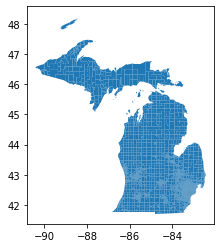

In [93]:
join = gpd.GeoDataFrame(pd.merge(df_with_avcb_and_stat_reallocated, shp, on = 'VTD2016', how = 'outer').drop_duplicates(), crs = crs)
join.plot()

In [94]:
join.shape

(4811, 42)

# Validation

## Shapefile

In [95]:
shp_final_merge = pd.merge(join, gdfv, on = 'VTD2016', how = 'outer', suffixes = ['_x', '_y'])

In [96]:
join['geometry'].geom_almost_equals(gdfv['geometry'], decimal = 0)

/Users/lilyfalk/anaconda3/envs/pdv_env/lib/python3.9/site-packages/geopandas/base.py:32: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


0       False
1       False
2       False
3       False
4       False
        ...  
4806    False
4807    False
4808    False
4809    False
4810    False
Length: 4811, dtype: bool

In [97]:
shp_shapes = gpd.GeoDataFrame(shp_final_merge, geometry = 'geometry_x')
final_shapes = gpd.GeoDataFrame(shp_final_merge, geometry = 'geometry_y')
vals = shp_shapes.geom_almost_equals(final_shapes, decimal = 0)

In [98]:
print(vals.value_counts())

True     4758
False      53
dtype: int64


In [99]:
print(shp_final_merge[~vals]['VTD2016'].str[0:3].value_counts())
diff_precincts = gpd.GeoDataFrame(shp_final_merge[~vals], geometry = 'geometry_x', crs = crs)

shp_difference = gpd.overlay(shp_shapes, final_shapes, how = 'symmetric_difference')
shp_difference.plot()

161    11
149     5
033     4
111     3
139     3
035     2
049     2
067     2
093     2
081     2
029     2
125     2
041     1
023     1
065     1
087     1
027     1
057     1
017     1
105     1
037     1
025     1
091     1
131     1
147     1
Name: VTD2016, dtype: int64


TopologyException: Input geom 1 is invalid: Ring Self-intersection at -83.918367499974863 42.597800500181734


TopologicalError: The operation 'GEOSDifference_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x13daa3130>

# Election result difference

In [100]:
column_list = ['G16PRERTru', 'G16PREGSte','G16PRELJoh', 'G16PREOth']

In [79]:
final_df_merge = pd.merge(df_with_avcb_and_stat_reallocated, gdfv, on = 'VTD2016', how = 'outer', suffixes = ('_x', '_y'))

In [80]:
final_df_merge.shape

(4812, 40)

In [81]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff != 0):
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]['VTD2016'])
                if (diff>max_diff):
                    max_diff = diff
                    #add line to check percent from total vote difference is
                    perc_diff_from_vest = (diff/df.iloc[j][right_Data])*100
                    print("New max diff is: ", str(max_diff))
                    print('% difference from VEST total is: ', str(perc_diff_from_vest))
                    print(df.iloc[j]['VTD2016'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]['VTD2016'])
        else:
            matching_rows +=1
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
        #add line for % of total vote that difference is
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 5")
    diff_list.sort()


In [82]:
validater_row(final_df_merge, column_list)

New max diff is:  1.0
% difference from VEST total is:  16.666666666666664
0010104000001
New max diff is:  2.0
% difference from VEST total is:  28.57142857142857
0011246000001
New max diff is:  3.0
% difference from VEST total is:  25.0
0370590000005
New max diff is:  85.0
% difference from VEST total is:  14.505119453924914
0372412000017
New max diff is:  328.0
% difference from VEST total is:  113.10344827586208
0452452000001
New max diff is:  473.0
% difference from VEST total is:  85.37906137184116
0452452000001
NaN value at diff is:  1252776000002
NaN value at diff is:  1252776000002
NaN value at diff is:  1252776000002
NaN value at diff is:  1252776000002
NaN value at diff is:  1252776000002
NaN value at diff is:  1476838000001
NaN value at diff is:  1476838000001
NaN value at diff is:  1476838000001
NaN value at diff is:  1476838000001
NaN value at diff is:  1476838000001
New max diff is:  499.0
% difference from VEST total is:  44.75336322869955
1632200005132
NaN value at diff

In [85]:
df_with_avcb_and_stat_reallocated[df_with_avcb_and_stat_reallocated['VTD2016'] == '1252776000002']

,candidate_id,county_code,city_town_code,ward_number,precinct_number,precinct_label,G16PREGSte,G16PREDCli,G16PRERTru,G16PRELJoh,...,G16PREDCli_floor,G16PRERTru_add,G16PRERTru_rem,G16PRERTru_floor,G16PRELJoh_add,G16PRELJoh_rem,G16PRELJoh_floor,G16PREOth_add,G16PREOth_rem,G16PREOth_floor
2928,2928,63,61,0,2,,0.0,3.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
['CASS', 'CLINTON', 'GLADWIN', 'LAPEER', 'ST. CLAIR', 'WAYNE']

In [84]:
gdfv[gdfv['VTD2016'] == '1632200005132']

,VTD2016,Label,G16PREDCli,G16PRERTru,G16PREGSte,G16PRELJoh,G16PREOth,geometry
3694,1632200005132,City of Detroit,1115,39,10,8,3,"POLYGON ((-82.98735 42.35179, -82.98987 42.351..."


In [223]:
gdfv[gdfv['unique_id'] == '02760900001']

,VTD2016,Label,G16PREDCli,G16PRERTru,G16PREGSte,G16PRELJoh,G16PREOth,geometry,join_tst1,county_fips,vtd2016_nowards,unique_id
416,0276090000001,Ontwa Township,539,1272,20,79,15,"POLYGON ((-86.04468 41.81071, -86.04469 41.807...",02760900001,027,02760900001,02760900001


- Peter tries some unique id then take what joins off of that
- if incorrect join it will come up later when you compare precinct by precinct election results
- for stuff that does not join, export to csv and look at that - manually line up
- map unique ids from one to the other to match
- rerunning the join - then left with the stuff where you have no idea where it is coming from
- if there are no unique ids at all, but you are able to 
